https://towardsdatascience.com/image-recognition-with-machine-learning-on-python-image-processing-3abe6b158e9a

In [1]:
# TODO:
# precision, recall, AUCPR plots with labeled axes
# finish narrative
# give descriptions of resources used
# make citations link to webpage
# expand Keras Tuner hyperparameter search space and run for more iterations
#  - depth
#  -

# Diagnosing Pneumonia from X-rays
## Introduction
In recent years, convolutional neural networks (CNNs) trained on radiological images such as x-rays have begun to outperform medical professionals in diagnosing disease. [1] In this notebook, I construct, train, and evaluate the performance of a CNN that predicts whether a patient has pneumonia based on a chest x-ray. I walk through the process step by step, including using Keras Tuner to tune the network hyperparameters.

In [2]:
# imports of main packages used
# submodule imports appear in the cell in which they are first used
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt  # tune Keras neural network hyperparameters

## Dataset
The dataset is available from Kaggle. [2] It consists of 5,856 .jpeg images of chest x-rays. 1,583 of the x-rays are from healthy patients (labeled as "NORMAL") and the other 4,273 x-rays are from patients with either viral or bacterial pneumonia (labeled as "PNEUMONIA"). Here, I do not make the distinction between viral and bacterial pneumonia, and all pneumonia cases are given the label of "PNEUMONIA".

Using `ImageDataGenerator()` and its `flow_from_directory` method [3] from the `tensorflow.keras.preprocessing.image` submodule makes it simple to load image files from a directory. The file hierarchy should have one folder for each class, and within each class folder, there should be one subfolder for training images and another subfolder for test images. Although there is a "val" directory to be used for validation, it contains only 8 examples of each class. This directory was skipped and the validation set was partitioned from the training set, as shown below. Some of the training images are also slightly altered in terms of positioning (x and y values) and skew (rotation) within the frame in order to represent the possible variation in images that may exist in data not yet seen by the model.

The resources in [4-7] give additional guidance about loading data using `ImageDataGenerator`.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

# make an ImageDataGenerator to load training and validation images
# rotate and translate some of the images to add variety to the dataset
generator_train = ImageDataGenerator(validation_split=0.2,
                                     rescale=1/255.,
                                     rotation_range=5,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1)

train_ds = generator_train.flow_from_directory(
    data_dir+'train',
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=0
    )

val_ds = generator_train.flow_from_directory(
    data_dir+'train', # same directory as training data
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    color_mode='rgb',
    shuffle=True,
    seed=0
    )

generator_test = ImageDataGenerator(rescale=1/255.)

test_ds = generator_test.flow_from_directory(
    data_dir+'test',
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
    )

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
# setting the class_mode to 'binary' in flow_from_directory replaces the labels with 0/1 - 
# recover which value corresponds to which class
class_dict = train_ds.class_indices
print(class_dict)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [5]:
# number of examples of each class in train, validation, and test partitions
label_dict = {v: k for k, v in class_dict.items()}
datasets = {'train': train_ds, 'validation': val_ds, 'test': test_ds}

for partition, ds in datasets.items():
    counts = pd.Series(ds.classes).value_counts().sort_index()
    counts.index = counts.index.map(label_dict)
    print(partition)
    print(counts)
    print('\n')

train
NORMAL       1073
PNEUMONIA    3100
dtype: int64


validation
NORMAL       268
PNEUMONIA    775
dtype: int64


test
NORMAL       234
PNEUMONIA    390
dtype: int64




## Data Exploration
The subplots below, as used in TensorFlow's classification tutorial, [8] show some examples of x-rays from the training set.

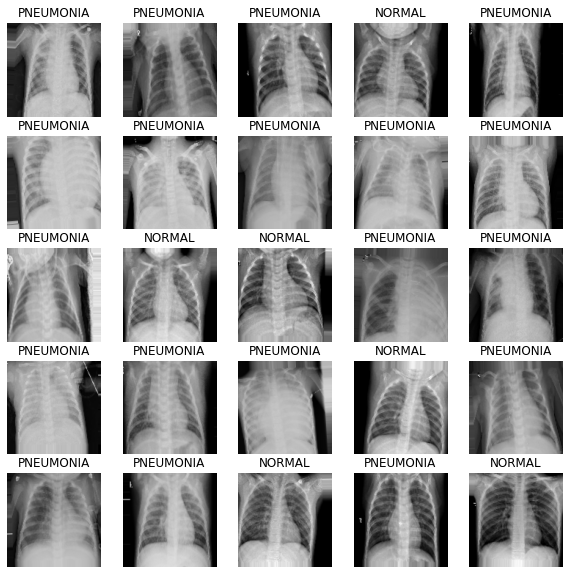

In [6]:
import matplotlib.pyplot as plt

X_train, y_train = next(train_ds)

plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i])
    label = 'NORMAL' if int(y_train[i]) == 0 else 'PNEUMONIA'
    plt.title(label)
    plt.axis("off")

## Model Training
Keras Tuner is used to create and randomly search a search space of neural network models with varying hyperparameter values. Here, the number of neurons in each layer is varied. The resources in [9] and [10] contain some guidance about how to specify hyperparameter values in the HyperModel object from Keras Tuner.

In [7]:
from keras_tuner import HyperModel
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Conv2D(filters=hp.Int('input_units',
                             min_value=128,
                             max_value=128,
                             step=32),
                             kernel_size=(3, 3),
                             input_shape=(128,128,3),
                             activation='relu'))
        
        model.add(MaxPooling2D((2,2)))
        
        model.add(Dropout(0.2))
         
        model.add(Conv2D(filters=hp.Int('input_units',
                             min_value=128,
                             max_value=128,
                             step=32),
                             kernel_size=(3, 3),
                             activation='relu'))

    
        model.add(MaxPooling2D((2,2)))
        
        model.add(Dropout(0.2))
        
        model.add(Conv2D(filters=hp.Int('input_units',
                             min_value=128,
                             max_value=128,
                             step=32),
                             kernel_size=(3, 3),
                             activation='relu'))

    
        model.add(MaxPooling2D((2,2)))
        
        model.add(Dropout(0.2))

        model.add(Flatten())
        
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        
        model.compile(optimizer='RMSprop',
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=['accuracy', tf.keras.metrics.AUC(curve='PR', name='AUCPR')],
                      weighted_metrics=['accuracy', tf.keras.metrics.AUC(curve='PR', name='AUCPR')])
        
        return model

In [8]:
# balance normal vs. pneumonia classes

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=[0,1], y=train_ds.labels)
class_weights = dict(enumerate(class_weights))
val_sample_weights = class_weight.compute_sample_weight('balanced',val_ds.labels)

In [9]:
# https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5

class LogCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

In [ ]:
# https://keras.io/api/keras_tuner/tuners/base_tuner/#tuner-class

log_callback = LogCallback()
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
hypermodel = MyHyperModel()
tuner_rs = kt.RandomSearch(
            hypermodel,
            objective=kt.Objective('val_loss', direction='min'),
            seed=0,
            max_trials=1,
            executions_per_trial=1)

with tf.device('/GPU:0'):
    tuner_rs.search(train_ds,
                    epochs=5,
                    verbose=1,
                    validation_data=val_ds,
                    class_weight=class_weights,
                    callbacks=[log_callback, early_stop_callback])


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
input_units       |128               |?                 

Epoch 1/5
131/131 [==============================] - 346s 3s/step - loss: 0.7683 - accuracy: 0.5100 - AUCPR: 0.8062 - weighted_accuracy: 0.5935 - weighted_AUCPR: 0.5984 - val_loss: 0.8403 - val_accuracy: 0.6165 - val_AUCPR: 0.9143 - val_weighted_accuracy: 0.6165 - val_weighted_AUCPR: 0.9143
Epoch 2/5
131/131 [==============================] - 336s 3s/step - loss: 0.5055 - accuracy: 0.7742 - AUCPR: 0.9290 - weighted_accuracy: 0.7883 - weighted_AUCPR: 0.8300 - val_loss: 0.5529 - val_accuracy: 0.7373 - val_AUCPR: 0.9363 - val_weighted_accuracy: 0.7373 - val_weighted_AUCPR: 0.9363
Epoch 3/5
131/131 [==============================] - 335s 3s/step - loss: 0.3924 - accuracy: 0.8361 - AUCPR: 0.9628 - weighted_accuracy: 0.8356 - weighted_AUCPR: 0.9064 - val_loss: 0.8154 - val_accuracy: 0.7919 - val_AUCPR: 0.9156 - val_weighted_accuracy: 0.7919 - val_weigh

In [21]:
model = tuner_rs.get_best_models(1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       1

## Evaluate Performance

In [22]:
model.evaluate(test_ds, verbose=1)
y_pred = model.predict(test_ds)
y_test = test_ds.labels

20/20 [==============================] - 17s 745ms/step - loss: 1.0047 - accuracy: 0.5878 - AUCPR: 0.5931 - weighted_accuracy: 0.5878 - weighted_AUCPR: 0.5931


In [33]:
y_pred_binary = [1 if x > 0.9 else 0 for x in y_pred]

# confusion matrix values are ordered as [[TN, FP],[FN, TP]]
cm = tf.math.confusion_matrix(y_test, y_pred_binary)
print(cm) # rows are true labels, columns are predicted

tf.Tensor(
[[181  53]
 [ 37 353]], shape=(2, 2), dtype=int32)


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       234
           1       0.87      0.91      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.84      0.84       624
weighted avg       0.85      0.86      0.85       624



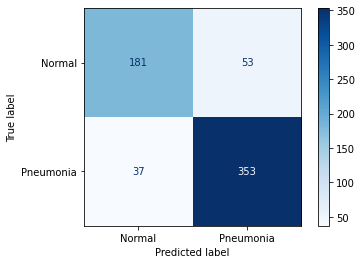

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_test, y_pred_binary)
ConfusionMatrixDisplay(cm, display_labels=["Normal", "Pneumonia"]).plot(cmap="Blues")

[1.         0.99743587 0.99743587 0.99743587 0.99743587 0.99743587
 0.99743587 0.99230766 0.9846154  0.9794872  0.974359   0.96410257
 0.96153843 0.9564102  0.9461538  0.93333334 0.92820513 0.9051282
 0.83589745]


<AxesSubplot:>

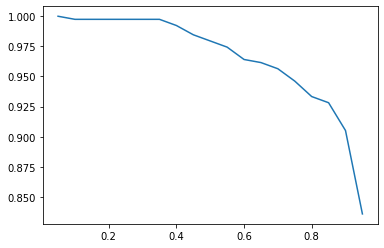

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# minimize false negatives = maximize recall / sensitivity (TP / (TP + FN))

m = tf.keras.metrics.Recall(thresholds = np.arange(0.05,1,0.05).tolist())
m.update_state(y_test,y_pred)
x = m.result().numpy()
print(x)
sns.lineplot(x=np.arange(0.05,1,0.05),y=x)

<AxesSubplot:>

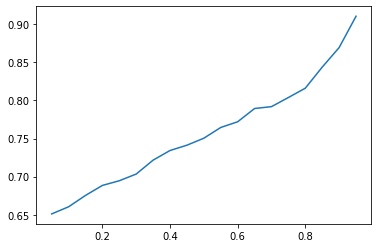

In [37]:
# maximize positive predictive value (precision)
m = tf.keras.metrics.Precision(thresholds = np.arange(0.05,1,0.05).tolist())
m.update_state(y_test,[x for x in y_pred])
x = m.result().numpy()
sns.lineplot(x=np.arange(0.05,1,0.05),y=x)

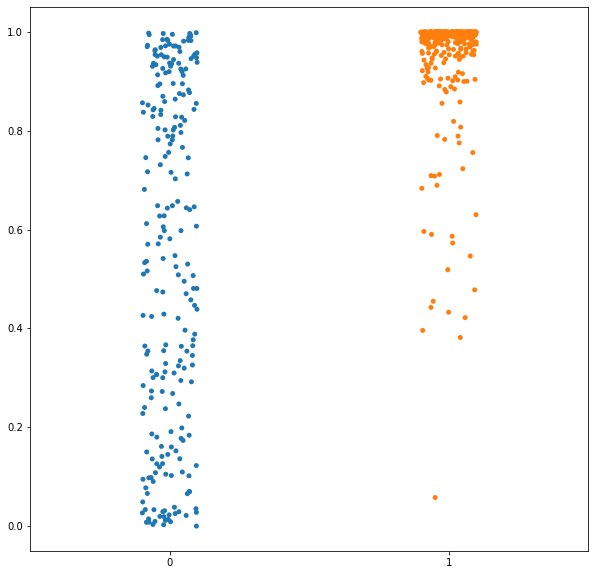

In [39]:
plt.figure(figsize=(10,10))
prob = np.array([x[0] for x in y_pred])
sns.stripplot(x=y_test, y=prob)
plt.show()

https://keras.io/api/metrics/classification_metrics/

## Citations

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8112196/ \
[2] https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia \
[3] 
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory \
[4] https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator \
[5] https://datascience.stackexchange.com/questions/113449/what-does-shuffle-and-seed-parameter-in-keras-image-gen-flow-from-directory-si \
[6] https://www.tensorflow.org/tutorials/load_data/images \
[7] https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720 \
[8] https://www.tensorflow.org/tutorials/keras/classification \
[9] https://pythonprogramming.net/keras-tuner-optimizing-neural-network-tutorial/ \
[10] https://towardsdatascience.com/hyperparameter-tuning-with-keras-tuner-283474fbfbe \
